In [1]:
import os
import json
import open3d as o3d
import numpy as np
import vispy
from vispy import io
import torch
from torch import tensor
import math
import random
import numbers
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from torch_geometric.data import Data
from torch_cluster import fps
from torch_geometric.transforms import Compose, RandomRotate, LinearTransformation
from torch_cluster import knn_graph
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from scipy.optimize import linear_sum_assignment as linear_assignment

In [2]:
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
            src = pos[src].tolist()
            dst = pos[dst].tolist()
            plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
        mask = torch.zeros(pos.size(0), dtype=torch.bool)
        mask[index] = True
        plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
        plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

In /home/melina/anaconda3/envs/i2dl/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/melina/anaconda3/envs/i2dl/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/melina/anaconda3/envs/i2dl/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/melina/anaconda3/envs/i2dl/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/melina/anac

In [3]:
def random_rotation(data):
    torch.manual_seed(123)
    random_rotate = Compose([
        RandomRotate(degrees=180, axis=0),
        RandomRotate(degrees=180, axis=1),
        RandomRotate(degrees=180, axis=2),
    ])
    return random_rotate(data)

In [4]:
def cosine_distance(input1, input2):
    norm1 = F.normalize(input1, 2, 1)
    norm2 = F.normalize(input2, 2, 1)
    cosine_similarity = torch.matmul(norm1,norm2.T)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

In [5]:
def contrastive_loss(origin_output, transform_output):
    num_nodes = origin_output.shape[0]
    dim_features = origin_output.shape[1]

    #compute the distance matrix
    pmatrix = cosine_distance(origin_output, transform_output)
    #print(pmatrix)
    #compute the contrastive loss
    diagonal = pmatrix * torch.eye(num_nodes)
    #print(diagonal)
    pos_dis = torch.sum(torch.square(diagonal), dim = (0,1)) / num_nodes

    non_diagonal = pmatrix - diagonal
    margin_matrix = margin * (torch.ones(num_nodes) - torch.eye(num_nodes))
    non_diagonal_margin =  margin_matrix - non_diagonal
    non_diagonal_dis = torch.maximum(torch.zeros(num_nodes), non_diagonal_margin)
    neg_dis = torch.sum(torch.square(non_diagonal_dis), dim = (0,1)) / (num_nodes * (num_nodes-1))
    #print(non_diagonal_dis)
    #print("pos loss", pos_dis)
    #print("neg loss", neg_dis)
    return pos_dis + neg_dis, pmatrix

## 1. Collect Dataset

In [6]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

ShapeNetdataset = ShapeNet(root='/home/melina/ShapeNet', categories=['Knife'])
print(ShapeNetdataset[0])
print(len(ShapeNetdataset))

Data(x=[2252, 3], y=[2252], pos=[2252, 3], category=[1])
312


In [7]:
LEN_DATASET = len(ShapeNetdataset)
dataset = []
for i in range (LEN_DATASET):
    print(str(i)*10)
    #get the original data
    data = ShapeNetdataset[i].clone().detach()   
    #print("original data:",data)
    num_data = data.x.shape[0]
    
    #downsample the original data
    if num_data > 1000:
        ratio = 0.05
    elif 500 < num_data < 1000:
        ratio = 0.1
    elif 100 < num_data < 500:
        ratio = 0.5
    else:
        ratio = 1
    index = fps(data.pos, ratio=ratio)   
    #visualize_points(data.pos)
    #visualize_points(data.pos, index=index)
    data.pos = data.pos[index]
    #print("data after downsampling:", data)
    
    #create the edges
    data.edge_index = knn_graph(data.pos, k=6)
    #visualize_points(data.pos, edge_index=data.edge_index)
    #print("data with edges:", data)
    
    #########transform the data randomly#########   
    #random rotation
    data_tr = data.clone().detach()
    data_tr = random_rotation(data_tr)

    #random translation
    random_translation = torch.rand(1, 3) #*0.1
    data_tr.pos = data_tr.pos + random_translation
    
    data.pos_tr = data_tr.pos.clone().detach()

    #visualize_points(data_tr.pos, edge_index=data.edge_index)
    #random_transformation = torch.cat((random_rotation, random_translation), 0)
    #data.transform = random_transformation.clone().detach()
    #print("transformation:", random_transformation)
    #print("transformed data:", data_tr)
    #print(data)
    dataset.append(data)    

0000000000
1111111111
2222222222
3333333333
4444444444
5555555555
6666666666
7777777777
8888888888
9999999999
10101010101010101010
11111111111111111111
12121212121212121212
13131313131313131313
14141414141414141414
15151515151515151515
16161616161616161616
17171717171717171717
18181818181818181818
19191919191919191919
20202020202020202020
21212121212121212121
22222222222222222222
23232323232323232323
24242424242424242424
25252525252525252525
26262626262626262626
27272727272727272727
28282828282828282828
29292929292929292929
30303030303030303030
31313131313131313131
32323232323232323232
33333333333333333333
34343434343434343434
35353535353535353535
36363636363636363636
37373737373737373737
38383838383838383838
39393939393939393939
40404040404040404040
41414141414141414141
42424242424242424242
43434343434343434343
44444444444444444444
45454545454545454545
46464646464646464646
47474747474747474747
48484848484848484848
49494949494949494949
50505050505050505050
51515151515151515151
52525252

308308308308308308308308308308
309309309309309309309309309309
310310310310310310310310310310
311311311311311311311311311311


In [8]:
data = dataset[0]

In [9]:
point_cloud1 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(data.pos)
point_cloud1.paint_uniform_color([1, 0, 0])
o3d.io.write_point_cloud("point_clouds/pc_3.ply", point_cloud1)
o3d.visualization.draw_geometries([point_cloud1])

In [10]:
point_cloud2 = o3d.geometry.PointCloud()
point_cloud2.points = o3d.utility.Vector3dVector(data.pos_tr)
point_cloud2.paint_uniform_color([0, 0, 1])
o3d.io.write_point_cloud("point_clouds/pc_4.ply", point_cloud2)
o3d.visualization.draw_geometries([point_cloud2])

In [11]:
train_dataset = dataset[:int(LEN_DATASET*0.85)]
test_dataset = dataset[int(LEN_DATASET*0.85):]
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0].pos[100])

265
47
tensor([ 0.0914, -0.2806, -0.0039])


In [12]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

## 2. Define the Network

In [13]:
from torch_geometric.nn import GraphUNet
    
GNNmodel = GraphUNet(in_channels = 3, hidden_channels = 128, out_channels = 512, depth = 4, \
                      pool_ratios=0.5, sum_res=True, act = torch.nn.functional.relu)
print(GNNmodel)

GraphUNet(3, 128, 512, depth=4, pool_ratios=[0.5, 0.5, 0.5, 0.5])


## 3. Training

Epoch: 00, Loss: 0.7168, Test Acc: 0.0162


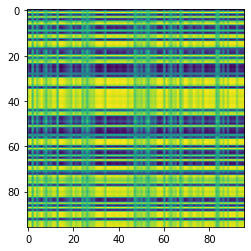

Epoch: 01, Loss: 0.5892, Test Acc: 0.0150
Epoch: 02, Loss: 0.5565, Test Acc: 0.0129
Epoch: 03, Loss: 0.5455, Test Acc: 0.0136
Epoch: 04, Loss: 0.5411, Test Acc: 0.0159
Epoch: 05, Loss: 0.5384, Test Acc: 0.0153
Epoch: 06, Loss: 0.5360, Test Acc: 0.0143
Epoch: 07, Loss: 0.5337, Test Acc: 0.0155
Epoch: 08, Loss: 0.5315, Test Acc: 0.0158
Epoch: 09, Loss: 0.5292, Test Acc: 0.0166
Epoch: 10, Loss: 0.5269, Test Acc: 0.0204


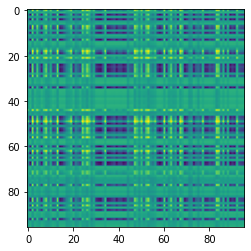

Epoch: 11, Loss: 0.5245, Test Acc: 0.0248
Epoch: 12, Loss: 0.5219, Test Acc: 0.0279
Epoch: 13, Loss: 0.5194, Test Acc: 0.0279
Epoch: 14, Loss: 0.5167, Test Acc: 0.0292
Epoch: 15, Loss: 0.5139, Test Acc: 0.0297
Epoch: 16, Loss: 0.5111, Test Acc: 0.0282
Epoch: 17, Loss: 0.5081, Test Acc: 0.0298
Epoch: 18, Loss: 0.5050, Test Acc: 0.0249
Epoch: 19, Loss: 0.5017, Test Acc: 0.0314
Epoch: 20, Loss: 0.4983, Test Acc: 0.0315


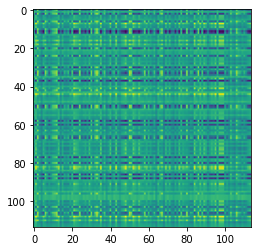

Epoch: 21, Loss: 0.4949, Test Acc: 0.0306
Epoch: 22, Loss: 0.4912, Test Acc: 0.0303
Epoch: 23, Loss: 0.4873, Test Acc: 0.0289
Epoch: 24, Loss: 0.4832, Test Acc: 0.0322
Epoch: 25, Loss: 0.4788, Test Acc: 0.0331
Epoch: 26, Loss: 0.4741, Test Acc: 0.0321
Epoch: 27, Loss: 0.4693, Test Acc: 0.0333
Epoch: 28, Loss: 0.4643, Test Acc: 0.0364
Epoch: 29, Loss: 0.4591, Test Acc: 0.0395
Epoch: 30, Loss: 0.4533, Test Acc: 0.0367


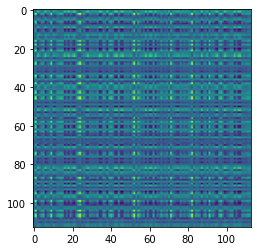

Epoch: 31, Loss: 0.4473, Test Acc: 0.0419
Epoch: 32, Loss: 0.4411, Test Acc: 0.0411
Epoch: 33, Loss: 0.4346, Test Acc: 0.0420
Epoch: 34, Loss: 0.4281, Test Acc: 0.0471
Epoch: 35, Loss: 0.4216, Test Acc: 0.0467
Epoch: 36, Loss: 0.4156, Test Acc: 0.0453
Epoch: 37, Loss: 0.4099, Test Acc: 0.0456
Epoch: 38, Loss: 0.4049, Test Acc: 0.0433
Epoch: 39, Loss: 0.4001, Test Acc: 0.0467
Epoch: 40, Loss: 0.3956, Test Acc: 0.0479


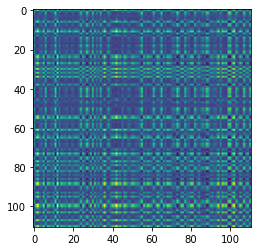

Epoch: 41, Loss: 0.3919, Test Acc: 0.0434
Epoch: 42, Loss: 0.3886, Test Acc: 0.0454
Epoch: 43, Loss: 0.3854, Test Acc: 0.0426
Epoch: 44, Loss: 0.3827, Test Acc: 0.0363
Epoch: 45, Loss: 0.3801, Test Acc: 0.0377
Epoch: 46, Loss: 0.3776, Test Acc: 0.0411
Epoch: 47, Loss: 0.3754, Test Acc: 0.0409
Epoch: 48, Loss: 0.3731, Test Acc: 0.0394
Epoch: 49, Loss: 0.3712, Test Acc: 0.0383
Epoch: 50, Loss: 0.3693, Test Acc: 0.0381


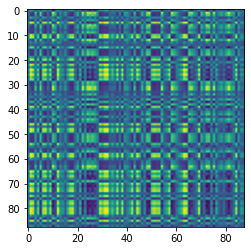

Epoch: 51, Loss: 0.3673, Test Acc: 0.0470
Epoch: 52, Loss: 0.3658, Test Acc: 0.0452
Epoch: 53, Loss: 0.3641, Test Acc: 0.0493
Epoch: 54, Loss: 0.3626, Test Acc: 0.0480
Epoch: 55, Loss: 0.3612, Test Acc: 0.0483
Epoch: 56, Loss: 0.3596, Test Acc: 0.0501
Epoch: 57, Loss: 0.3582, Test Acc: 0.0540
Epoch: 58, Loss: 0.3571, Test Acc: 0.0569
Epoch: 59, Loss: 0.3558, Test Acc: 0.0598
Epoch: 60, Loss: 0.3554, Test Acc: 0.0608


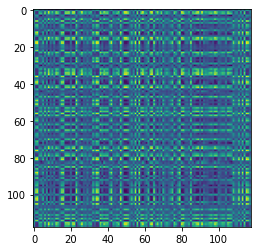

Epoch: 61, Loss: 0.3536, Test Acc: 0.0614
Epoch: 62, Loss: 0.3524, Test Acc: 0.0643
Epoch: 63, Loss: 0.3513, Test Acc: 0.0614
Epoch: 64, Loss: 0.3503, Test Acc: 0.0629
Epoch: 65, Loss: 0.3492, Test Acc: 0.0643
Epoch: 66, Loss: 0.3482, Test Acc: 0.0636
Epoch: 67, Loss: 0.3473, Test Acc: 0.0679
Epoch: 68, Loss: 0.3464, Test Acc: 0.0682
Epoch: 69, Loss: 0.3456, Test Acc: 0.0686
Epoch: 70, Loss: 0.3446, Test Acc: 0.0648


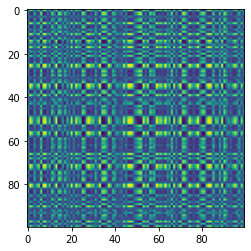

Epoch: 71, Loss: 0.3438, Test Acc: 0.0713
Epoch: 72, Loss: 0.3430, Test Acc: 0.0693
Epoch: 73, Loss: 0.3423, Test Acc: 0.0654
Epoch: 74, Loss: 0.3415, Test Acc: 0.0704
Epoch: 75, Loss: 0.3410, Test Acc: 0.0663
Epoch: 76, Loss: 0.3403, Test Acc: 0.0705
Epoch: 77, Loss: 0.3397, Test Acc: 0.0731
Epoch: 78, Loss: 0.3391, Test Acc: 0.0704
Epoch: 79, Loss: 0.3386, Test Acc: 0.0771
Epoch: 80, Loss: 0.3378, Test Acc: 0.0740


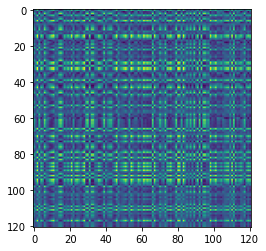

Epoch: 81, Loss: 0.3374, Test Acc: 0.0805
Epoch: 82, Loss: 0.3366, Test Acc: 0.0773
Epoch: 83, Loss: 0.3363, Test Acc: 0.0814
Epoch: 84, Loss: 0.3357, Test Acc: 0.0815
Epoch: 85, Loss: 0.3353, Test Acc: 0.0865
Epoch: 86, Loss: 0.3349, Test Acc: 0.0843
Epoch: 87, Loss: 0.3343, Test Acc: 0.0850
Epoch: 88, Loss: 0.3339, Test Acc: 0.0882
Epoch: 89, Loss: 0.3333, Test Acc: 0.0837
Epoch: 90, Loss: 0.3331, Test Acc: 0.0876


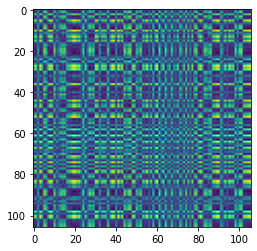

Epoch: 91, Loss: 0.3325, Test Acc: 0.0843
Epoch: 92, Loss: 0.3321, Test Acc: 0.0848
Epoch: 93, Loss: 0.3317, Test Acc: 0.0856
Epoch: 94, Loss: 0.3313, Test Acc: 0.0898
Epoch: 95, Loss: 0.3308, Test Acc: 0.0822
Epoch: 96, Loss: 0.3304, Test Acc: 0.0891
Epoch: 97, Loss: 0.3300, Test Acc: 0.1025
Epoch: 98, Loss: 0.3296, Test Acc: 0.0990
Epoch: 99, Loss: 0.3292, Test Acc: 0.1029
Epoch: 100, Loss: 0.3289, Test Acc: 0.1027


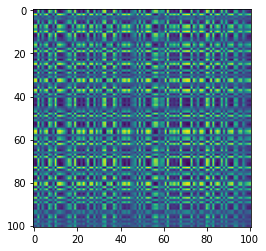

Epoch: 101, Loss: 0.3285, Test Acc: 0.1057
Epoch: 102, Loss: 0.3281, Test Acc: 0.0990
Epoch: 103, Loss: 0.3278, Test Acc: 0.0963
Epoch: 104, Loss: 0.3274, Test Acc: 0.0952
Epoch: 105, Loss: 0.3269, Test Acc: 0.0951
Epoch: 106, Loss: 0.3267, Test Acc: 0.1028
Epoch: 107, Loss: 0.3262, Test Acc: 0.1044
Epoch: 108, Loss: 0.3260, Test Acc: 0.1020
Epoch: 109, Loss: 0.3257, Test Acc: 0.1063
Epoch: 110, Loss: 0.3254, Test Acc: 0.1052


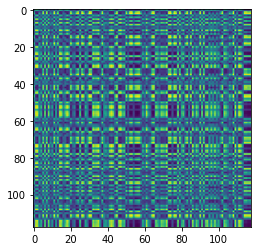

Epoch: 111, Loss: 0.3249, Test Acc: 0.1049
Epoch: 112, Loss: 0.3245, Test Acc: 0.1038
Epoch: 113, Loss: 0.3241, Test Acc: 0.1010
Epoch: 114, Loss: 0.3239, Test Acc: 0.1012
Epoch: 115, Loss: 0.3234, Test Acc: 0.1012
Epoch: 116, Loss: 0.3232, Test Acc: 0.0951
Epoch: 117, Loss: 0.3228, Test Acc: 0.0982
Epoch: 118, Loss: 0.3225, Test Acc: 0.0987
Epoch: 119, Loss: 0.3222, Test Acc: 0.1011
Epoch: 120, Loss: 0.3220, Test Acc: 0.1004


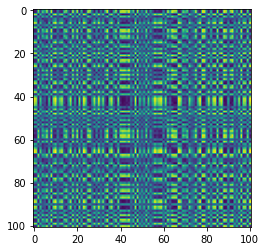

Epoch: 121, Loss: 0.3216, Test Acc: 0.1013
Epoch: 122, Loss: 0.3214, Test Acc: 0.1015
Epoch: 123, Loss: 0.3211, Test Acc: 0.1016
Epoch: 124, Loss: 0.3209, Test Acc: 0.1087
Epoch: 125, Loss: 0.3206, Test Acc: 0.1046
Epoch: 126, Loss: 0.3201, Test Acc: 0.1048
Epoch: 127, Loss: 0.3201, Test Acc: 0.1082
Epoch: 128, Loss: 0.3197, Test Acc: 0.1126
Epoch: 129, Loss: 0.3193, Test Acc: 0.1060
Epoch: 130, Loss: 0.3190, Test Acc: 0.1115


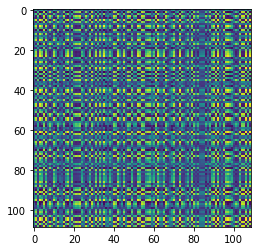

Epoch: 131, Loss: 0.3186, Test Acc: 0.1056
Epoch: 132, Loss: 0.3184, Test Acc: 0.1088
Epoch: 133, Loss: 0.3180, Test Acc: 0.1073
Epoch: 134, Loss: 0.3175, Test Acc: 0.1089
Epoch: 135, Loss: 0.3172, Test Acc: 0.1068
Epoch: 136, Loss: 0.3171, Test Acc: 0.1084
Epoch: 137, Loss: 0.3167, Test Acc: 0.0994
Epoch: 138, Loss: 0.3165, Test Acc: 0.0998
Epoch: 139, Loss: 0.3160, Test Acc: 0.1046
Epoch: 140, Loss: 0.3156, Test Acc: 0.1022


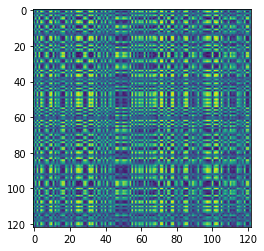

Epoch: 141, Loss: 0.3152, Test Acc: 0.1025
Epoch: 142, Loss: 0.3152, Test Acc: 0.1035
Epoch: 143, Loss: 0.3147, Test Acc: 0.0992
Epoch: 144, Loss: 0.3144, Test Acc: 0.0967
Epoch: 145, Loss: 0.3141, Test Acc: 0.0998
Epoch: 146, Loss: 0.3138, Test Acc: 0.0992
Epoch: 147, Loss: 0.3135, Test Acc: 0.0996
Epoch: 148, Loss: 0.3133, Test Acc: 0.0993
Epoch: 149, Loss: 0.3128, Test Acc: 0.1082
Epoch: 150, Loss: 0.3125, Test Acc: 0.1055


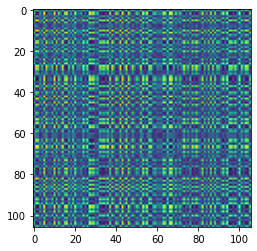

Epoch: 151, Loss: 0.3123, Test Acc: 0.1115
Epoch: 152, Loss: 0.3120, Test Acc: 0.1056
Epoch: 153, Loss: 0.3115, Test Acc: 0.1093
Epoch: 154, Loss: 0.3113, Test Acc: 0.1067
Epoch: 155, Loss: 0.3110, Test Acc: 0.1057
Epoch: 156, Loss: 0.3107, Test Acc: 0.1059
Epoch: 157, Loss: 0.3105, Test Acc: 0.1175
Epoch: 158, Loss: 0.3102, Test Acc: 0.1084
Epoch: 159, Loss: 0.3099, Test Acc: 0.1091
Epoch: 160, Loss: 0.3097, Test Acc: 0.1067


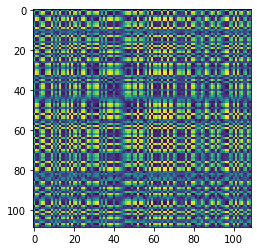

Epoch: 161, Loss: 0.3094, Test Acc: 0.1065
Epoch: 162, Loss: 0.3092, Test Acc: 0.1079
Epoch: 163, Loss: 0.3088, Test Acc: 0.1070
Epoch: 164, Loss: 0.3086, Test Acc: 0.1087
Epoch: 165, Loss: 0.3084, Test Acc: 0.1095
Epoch: 166, Loss: 0.3079, Test Acc: 0.1149
Epoch: 167, Loss: 0.3076, Test Acc: 0.1087
Epoch: 168, Loss: 0.3075, Test Acc: 0.1237
Epoch: 169, Loss: 0.3071, Test Acc: 0.1235
Epoch: 170, Loss: 0.3068, Test Acc: 0.1225


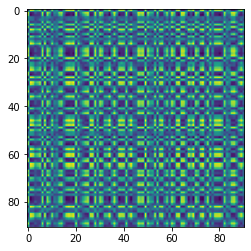

Epoch: 171, Loss: 0.3066, Test Acc: 0.1216
Epoch: 172, Loss: 0.3062, Test Acc: 0.1263
Epoch: 173, Loss: 0.3060, Test Acc: 0.1101
Epoch: 174, Loss: 0.3058, Test Acc: 0.1230
Epoch: 175, Loss: 0.3054, Test Acc: 0.1228
Epoch: 176, Loss: 0.3053, Test Acc: 0.1258
Epoch: 177, Loss: 0.3048, Test Acc: 0.1269
Epoch: 178, Loss: 0.3046, Test Acc: 0.1267
Epoch: 179, Loss: 0.3044, Test Acc: 0.1265
Epoch: 180, Loss: 0.3041, Test Acc: 0.1249


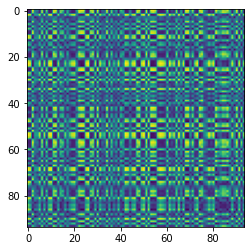

Epoch: 181, Loss: 0.3038, Test Acc: 0.1208
Epoch: 182, Loss: 0.3035, Test Acc: 0.1183
Epoch: 183, Loss: 0.3032, Test Acc: 0.1192
Epoch: 184, Loss: 0.3030, Test Acc: 0.1219
Epoch: 185, Loss: 0.3028, Test Acc: 0.1192
Epoch: 186, Loss: 0.3024, Test Acc: 0.1180
Epoch: 187, Loss: 0.3021, Test Acc: 0.1018
Epoch: 188, Loss: 0.3020, Test Acc: 0.1185
Epoch: 189, Loss: 0.3017, Test Acc: 0.1150
Epoch: 190, Loss: 0.3013, Test Acc: 0.1086


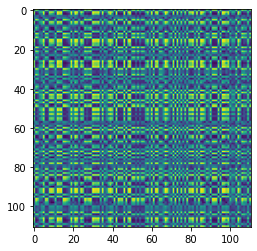

Epoch: 191, Loss: 0.3013, Test Acc: 0.1176
Epoch: 192, Loss: 0.3008, Test Acc: 0.1157
Epoch: 193, Loss: 0.3005, Test Acc: 0.1261
Epoch: 194, Loss: 0.3004, Test Acc: 0.1184
Epoch: 195, Loss: 0.3001, Test Acc: 0.1190
Epoch: 196, Loss: 0.2998, Test Acc: 0.1301
Epoch: 197, Loss: 0.2995, Test Acc: 0.1225
Epoch: 198, Loss: 0.2994, Test Acc: 0.1283
Epoch: 199, Loss: 0.2990, Test Acc: 0.1317
Epoch: 200, Loss: 0.2989, Test Acc: 0.1281


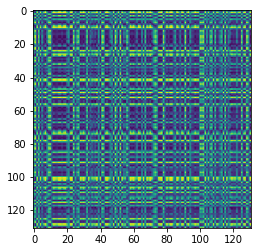

Epoch: 201, Loss: 0.2985, Test Acc: 0.1306
Epoch: 202, Loss: 0.2984, Test Acc: 0.1305
Epoch: 203, Loss: 0.2980, Test Acc: 0.1260
Epoch: 204, Loss: 0.2978, Test Acc: 0.1221
Epoch: 205, Loss: 0.2976, Test Acc: 0.1288
Epoch: 206, Loss: 0.2974, Test Acc: 0.1248
Epoch: 207, Loss: 0.2972, Test Acc: 0.1291
Epoch: 208, Loss: 0.2968, Test Acc: 0.1253
Epoch: 209, Loss: 0.2967, Test Acc: 0.1265
Epoch: 210, Loss: 0.2964, Test Acc: 0.1264


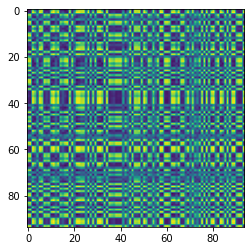

Epoch: 211, Loss: 0.2962, Test Acc: 0.1261
Epoch: 212, Loss: 0.2960, Test Acc: 0.1288
Epoch: 213, Loss: 0.2957, Test Acc: 0.1264
Epoch: 214, Loss: 0.2952, Test Acc: 0.1181
Epoch: 215, Loss: 0.2952, Test Acc: 0.1345
Epoch: 216, Loss: 0.2950, Test Acc: 0.1193
Epoch: 217, Loss: 0.2944, Test Acc: 0.1279
Epoch: 218, Loss: 0.2944, Test Acc: 0.1272
Epoch: 219, Loss: 0.2941, Test Acc: 0.1225
Epoch: 220, Loss: 0.2940, Test Acc: 0.1232


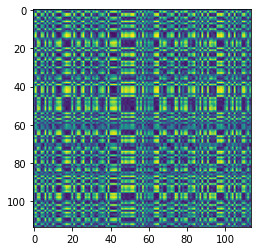

Epoch: 221, Loss: 0.2936, Test Acc: 0.1314
Epoch: 222, Loss: 0.2935, Test Acc: 0.1403
Epoch: 223, Loss: 0.2932, Test Acc: 0.1234
Epoch: 224, Loss: 0.2931, Test Acc: 0.1400
Epoch: 225, Loss: 0.2926, Test Acc: 0.1231
Epoch: 226, Loss: 0.2924, Test Acc: 0.1284
Epoch: 227, Loss: 0.2922, Test Acc: 0.1404
Epoch: 228, Loss: 0.2919, Test Acc: 0.1308
Epoch: 229, Loss: 0.2917, Test Acc: 0.1359
Epoch: 230, Loss: 0.2917, Test Acc: 0.1187


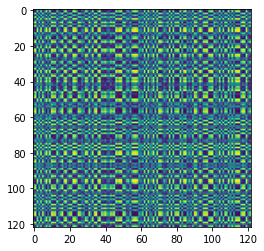

Epoch: 231, Loss: 0.2914, Test Acc: 0.1273
Epoch: 232, Loss: 0.2911, Test Acc: 0.1304
Epoch: 233, Loss: 0.2909, Test Acc: 0.1322
Epoch: 234, Loss: 0.2908, Test Acc: 0.1207
Epoch: 235, Loss: 0.2904, Test Acc: 0.1193
Epoch: 236, Loss: 0.2901, Test Acc: 0.1386
Epoch: 237, Loss: 0.2899, Test Acc: 0.1272
Epoch: 238, Loss: 0.2897, Test Acc: 0.1439
Epoch: 239, Loss: 0.2895, Test Acc: 0.1359
Epoch: 240, Loss: 0.2892, Test Acc: 0.1352


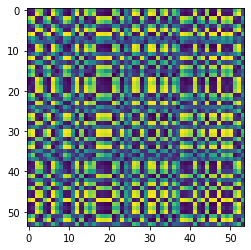

Epoch: 241, Loss: 0.2889, Test Acc: 0.1254
Epoch: 242, Loss: 0.2887, Test Acc: 0.1181
Epoch: 243, Loss: 0.2884, Test Acc: 0.1270
Epoch: 244, Loss: 0.2884, Test Acc: 0.1349
Epoch: 245, Loss: 0.2881, Test Acc: 0.1293
Epoch: 246, Loss: 0.2880, Test Acc: 0.1303
Epoch: 247, Loss: 0.2877, Test Acc: 0.1238
Epoch: 248, Loss: 0.2876, Test Acc: 0.1364
Epoch: 249, Loss: 0.2874, Test Acc: 0.1352
Epoch: 250, Loss: 0.2871, Test Acc: 0.1224


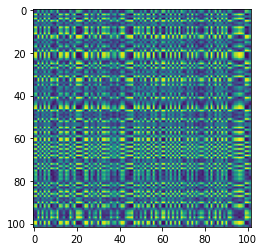

Epoch: 251, Loss: 0.2868, Test Acc: 0.1360
Epoch: 252, Loss: 0.2864, Test Acc: 0.1302
Epoch: 253, Loss: 0.2864, Test Acc: 0.1399
Epoch: 254, Loss: 0.2860, Test Acc: 0.1401
Epoch: 255, Loss: 0.2860, Test Acc: 0.1260
Epoch: 256, Loss: 0.2856, Test Acc: 0.1431
Epoch: 257, Loss: 0.2856, Test Acc: 0.1422
Epoch: 258, Loss: 0.2853, Test Acc: 0.1390
Epoch: 259, Loss: 0.2851, Test Acc: 0.1362
Epoch: 260, Loss: 0.2849, Test Acc: 0.1423


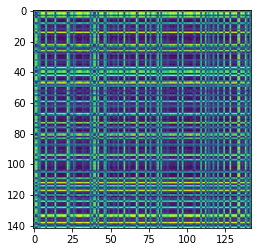

Epoch: 261, Loss: 0.2847, Test Acc: 0.1437
Epoch: 262, Loss: 0.2845, Test Acc: 0.1405
Epoch: 263, Loss: 0.2844, Test Acc: 0.1450
Epoch: 264, Loss: 0.2843, Test Acc: 0.1476
Epoch: 265, Loss: 0.2842, Test Acc: 0.1526
Epoch: 266, Loss: 0.2841, Test Acc: 0.1361
Epoch: 267, Loss: 0.2839, Test Acc: 0.1376
Epoch: 268, Loss: 0.2834, Test Acc: 0.1407
Epoch: 269, Loss: 0.2837, Test Acc: 0.1430
Epoch: 270, Loss: 0.2834, Test Acc: 0.1445


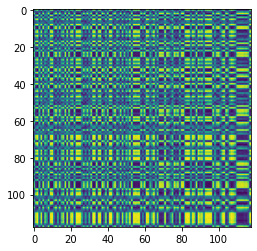

Epoch: 271, Loss: 0.2834, Test Acc: 0.1371
Epoch: 272, Loss: 0.2829, Test Acc: 0.1284
Epoch: 273, Loss: 0.2830, Test Acc: 0.1373
Epoch: 274, Loss: 0.2826, Test Acc: 0.1298
Epoch: 275, Loss: 0.2826, Test Acc: 0.1389
Epoch: 276, Loss: 0.2823, Test Acc: 0.1311
Epoch: 277, Loss: 0.2821, Test Acc: 0.1391
Epoch: 278, Loss: 0.2820, Test Acc: 0.1321
Epoch: 279, Loss: 0.2819, Test Acc: 0.1352
Epoch: 280, Loss: 0.2816, Test Acc: 0.1394


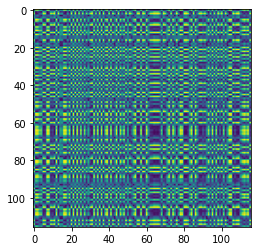

Epoch: 281, Loss: 0.2813, Test Acc: 0.1361
Epoch: 282, Loss: 0.2811, Test Acc: 0.1398
Epoch: 283, Loss: 0.2809, Test Acc: 0.1458
Epoch: 284, Loss: 0.2809, Test Acc: 0.1380
Epoch: 285, Loss: 0.2805, Test Acc: 0.1431
Epoch: 286, Loss: 0.2804, Test Acc: 0.1407
Epoch: 287, Loss: 0.2799, Test Acc: 0.1393
Epoch: 288, Loss: 0.2798, Test Acc: 0.1348
Epoch: 289, Loss: 0.2794, Test Acc: 0.1330
Epoch: 290, Loss: 0.2793, Test Acc: 0.1359


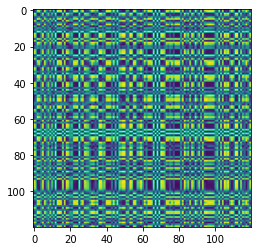

Epoch: 291, Loss: 0.2789, Test Acc: 0.1439
Epoch: 292, Loss: 0.2788, Test Acc: 0.1333
Epoch: 293, Loss: 0.2785, Test Acc: 0.1373
Epoch: 294, Loss: 0.2782, Test Acc: 0.1337
Epoch: 295, Loss: 0.2778, Test Acc: 0.1472
Epoch: 296, Loss: 0.2774, Test Acc: 0.1481
Epoch: 297, Loss: 0.2774, Test Acc: 0.1395
Epoch: 298, Loss: 0.2771, Test Acc: 0.1419
Epoch: 299, Loss: 0.2769, Test Acc: 0.1473


In [14]:
n_epoch =300
margin = 1
optimizer = optim.Adam(GNNmodel.parameters(), lr=5e-6)

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        
        #compute the embeddings
        origin_output = model(data.pos, data.edge_index)
        transform_output = model(data.pos_tr, data.edge_index)

        loss, pmatrix =  contrastive_loss(origin_output, transform_output)
        #print(loss.item())
                
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader), pmatrix

@torch.no_grad()
def test(model, loader):
    model.eval()
    
    total_correct = 0
    for data in loader:
        #compute the embeddings
        origin_output = model(data.pos, data.edge_index)
        transform_output = model(data.pos_tr, data.edge_index)
        
        loss, pmatrix =  contrastive_loss(origin_output, transform_output)
        #total_loss += loss.item() * data.num_graphs
        row_idx, col_idx = linear_assignment(pmatrix.detach().numpy())
        num_match = torch.sum(torch.where(torch.tensor(row_idx) == torch.tensor(col_idx),1,0))
        test_acc = num_match / data.pos.shape[0]
        total_correct += test_acc

    return total_correct / len(loader)


for epoch in range(0, n_epoch):
    loss, pmatrix = train(GNNmodel, optimizer, train_loader)
    test_acc = test(GNNmodel, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

    if epoch %10 == 0:
        plt.imshow(pmatrix.detach().cpu().numpy())
        plt.show()


In [14]:
print(pmatrix[0])

tensor([0.1948, 0.8292, 1.3057, 1.7262, 1.8115, 0.6962, 1.0075, 1.4215, 1.4065,
        1.0386, 0.6846, 1.7085, 1.5205, 0.1835, 1.0076, 1.6634, 0.7412, 0.7352,
        0.5523, 0.8314, 1.7254, 0.6635, 1.7806, 0.7031, 1.5338, 1.0332, 0.1896,
        1.4356, 1.0081, 0.8247, 0.4498, 0.2200, 1.7245, 1.1505, 0.9509, 0.8654,
        1.5121, 1.7437, 0.3328, 0.9180, 1.6782, 0.5023, 1.8083, 0.4685, 0.4063,
        0.9543, 0.4643, 1.8111, 1.7071, 0.2780, 1.4200, 0.9774, 1.0489, 1.0163,
        1.7561, 1.7330, 1.2481, 1.0223, 1.4371, 1.7036, 0.8654, 1.0289, 0.2063,
        0.4910, 1.6404, 0.1881, 1.0362, 0.2737, 1.7222, 1.7201, 0.9262, 1.7590,
        0.7046, 0.5142, 1.2148, 1.7738, 0.9793, 0.2713, 0.2012, 1.4244, 0.4612,
        1.8109, 0.1840, 1.3750, 0.3774, 1.0762, 0.5585, 1.5173, 1.7276, 0.5259,
        0.9503, 1.0487, 0.7918, 1.6324, 1.5728, 1.4484, 1.0504, 0.2699, 0.9514,
        1.2398, 1.5261, 1.0887, 0.8234, 1.6896, 1.7020, 0.7582, 0.7134, 1.6173,
        0.9927, 0.2024, 1.0095, 0.5857, 

In [15]:
total_acc = 0
for test_data in test_dataset:
    origin_output = GNNmodel(test_data.pos, test_data.edge_index)
    transform_output = GNNmodel(test_data.pos_tr, test_data.edge_index)
    pmatrix =  cosine_distance(origin_output, transform_output)
    match = torch.argmin(pmatrix, 0)
    num_match = 0
    for i in range(len(match)):
        if match[i] == i:
            num_match += 1
    test_acc = num_match / test_data.pos.shape[0]
    total_acc += test_acc
    print(test_acc)
mean_acc = total_acc/len(test_dataset)
print("mean_acc", mean_acc)

0.007352941176470588
0.0784313725490196
0.12871287128712872
0.06837606837606838
0.016129032258064516
0.04950495049504951
0.03361344537815126
0.07339449541284404
0.10185185185185185
0.088
0.049586776859504134
0.07692307692307693
0.07608695652173914
0.056910569105691054
0.02631578947368421
0.1134020618556701
0.04032258064516129
0.008695652173913044
0.12727272727272726
0.04395604395604396
0.026785714285714284
0.05982905982905983
0.03508771929824561
0.032520325203252036
0.04580152671755725
0.011764705882352941
0.07518796992481203
0.03731343283582089
0.05194805194805195
0.04424778761061947
0.07894736842105263
0.0970873786407767
0.06299212598425197
0.04504504504504504
0.0
0.05454545454545454
0.05
0.08208955223880597
0.03496503496503497
0.0390625
0.056074766355140186
0.017391304347826087
0.036036036036036036
0.007575757575757576
0.07142857142857142
0.08196721311475409
0.05737704918032787
mean_acc 0.054423632233748534


In [16]:
#save the model
PATH = "/home/melina/桌面/jupyter/intellisys/week5/models/GNNmodel_5.p"
torch.save(GNNmodel.state_dict(),PATH)